In [16]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

Using TensorFlow backend.


In [62]:
import cobra
%load_ext autoreload
import sys
if not '/home/nlarusstone/cf_fba' in sys.path:
    sys.path.append('/home/nlarusstone/cf_fba')
import src.utils as utils
import src.flux_utils as futils
import src.flux_sample as fs
import src.create_dataset as dataset
from src.get_test_data import get_test_data
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
latent_dim = 2
use_corr = True
froot = 'hand'
txtl = True
resamp = True
layer_szs = [1024, 1024, 1024]

In [65]:
encoder, generator, X_test, y_test, obj_col, cols, y_vals_d, test_enc, test_dec = get_test_data(
    froot, txtl, resamp, latent_dim, layer_szs, use_corr=True)

Read in data
Encoded data
Decoded data


In [21]:
stds = X_test.std(axis=0).mean(axis=0)
recon_stds = test_dec.std(axis=0).mean(axis=0)
rxn_nums = range(X_test.shape[-1])

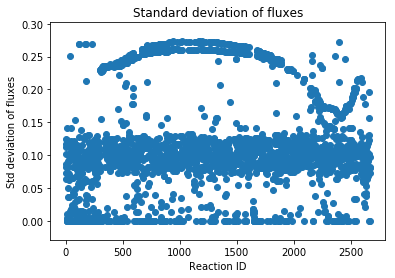

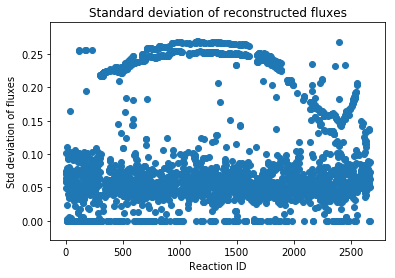

In [67]:
def plt_stds(rxns, stds, recon):
    plt.scatter(rxns, stds)
    plt.ylabel('Std deviation of fluxes')
    plt.xlabel('Reaction ID')
    plt.title('Standard deviation of {0}fluxes'.format('reconstructed ' if recon else ''))
    plt.show()
plt_stds(rxn_nums, stds, recon=False)
plt_stds(rxn_nums, recon_stds, recon=True)

In [ ]:
def pred(biased_resamp_data, enc, gen):
    encoded_biased = enc.predict(biased_resamp_data)
    decoded_biased = gen.predict(encoded_biased)
    return check_corr(decoded_biased, df, btol_col)
pred(biased_resamp_data, enc, gen)
pred(biased_resamp_data, enc2, gen2)

In [ ]:
def add_noise(biased_resamp_data, enc, gen):
    noise_arr = np.logspace(start=-5, stop=1, num=10)
    corrs = []
    for noise in noise_arr:
        noisy_data = biased_resamp_data.copy()
        for i in range(n_experiments):
            s = noisy_data[:, i, :].shape
            noisy_data[:, i, :] += np.random.normal(scale=noise, size=s)
            #noisy_data[:, i, :] = minmax_scale(noisy_data[:, i, :])
        #scaled_noisy_data = scale_by_flux(noisy_data)
        corr = pred(noisy_data, enc, gen)
        corrs.append(corr)
    return zip(noise_arr, corrs) + [(0, pred(biased_resamp_data, enc, gen))]
noise_res = add_noise(biased_resamp_data, enc, gen)
noise_res2 = add_noise(biased_resamp_data, enc_good, gen_good)
noise_res3 = add_noise(biased_resamp_data, enc_bad, gen_bad)

In [ ]:
orig_corr = check_corr(biased_resamp_data, df, btol_col)
def plt_noise_corr(noise_data, orig_corr, ndim=2):
    orig_enc, noise_data = noise_data[-1], noise_data[:-1]
    plt.figure(figsize=(10, 8))
    plt.title('Latent dimension = {0}'.format(ndim))
    plt.axhline(y=-1 * orig_enc[1] if orig_enc[1] < 0 else orig_enc[1], label='Original data encoded')
    plt.axhline(y=orig_corr, label='Original data correlation', c='g')
    for noise, corr in noise_data:
        plt.scatter(x=noise, y=-1 * corr if corr < 0 else corr)
        plt.xlabel('Noise amount')
        plt.ylabel('Correlation')
    plt.xscale('log')
    plt.legend()
    plt.show()
plt_noise_corr(noise_res, orig_corr, ndim=2)
#plt_noise_corr(noise_res2, orig_corr, ndim=10)
#plt_noise_corr(noise_res3, orig_corr, ndim='2, no correlation loss')